# Calling necessary libraries

In [ ]:
# !pip install gurobipy
import numpy as np
from gurobipy import Model,GRB
from gurobipy import quicksum as qsm
import pandas as pd
from itertools import product as prd
import matplotlib.pyplot as plt
from tqdm import tqdm


# Generating A,x,b
## Separation model
```Separation``` by using Gurobi python API, finds the optimal solution for the separation model

In [ ]:
def Seperation(A,b,x):

  md = Model('Seperation')
  lm = md.addVars(range(A.shape[0]),vtype=GRB.INTEGER, ub=999,name='lambda')
  fi_A = md.addVars(range(A.shape[1]),vtype=GRB.INTEGER, name='phi_A')
  fi_b = md.addVar(vtype=GRB.INTEGER, name='phi_B')
  md.addConstrs(qsm(lm[i]*A[i,j]/1000 for i in range(A.shape[0]))>=fi_A[j] for j in range(A.shape[1]))
  md.addConstrs(qsm(lm[i]*A[i,j]/1000 for i in range(A.shape[0]))<=fi_A[j]+0.999 for j in range(A.shape[1]))
  md.addConstr(qsm(lm[i]*b[i,0]/1000 for i in range(b.shape[0]))>=fi_b)
  md.addConstr(qsm(lm[i]*b[i,0]/1000 for i in range(b.shape[0]))<=fi_b+0.999)
  md.addConstr(qsm(lm[i] for i in lm)<=1000)
  md.setObjective(qsm(fi_A[j]*x[j,0] for j in range(x.shape[0]))-fi_b,GRB.MAXIMIZE)
  md.optimize()
  lms = md.getAttr('X',lm)
  return np.array([lms[i]/1000 for i in lms]).reshape(A.shape[0],1)

In [ ]:
cnt = 0
DF = {}
data = {}
Total_number_instances = 5
while cnt<=Total_number_instances:
  m,n = np.random.randint(2,11),np.random.randint(2,6)
  A = np.random.randint(-5,20,(m,n))
  c = np.random.randint(1,5,(n,1))
  x = (np.random.rand(n,1)>=0.25).astype(int)
  s = np.random.randint(0,6,(m,1))
  b = A.dot(x)+s
  mip = Model('MIP')
  mip.setParam('OutputFlag',0)
  x_v = mip.addVars(range(n),ub = 1,vtype=GRB.CONTINUOUS,name='x')
  mip.addConstrs(qsm(A[i,j]*x_v[j] for j in range(n))<=b[i,0] for i in range(m))
  mip.setObjective(qsm(x_v[j]*c[j,0] for j in range(n)),GRB.MAXIMIZE)
  mip.optimize()
  if mip.Status == GRB.OPTIMAL:
    x_s = np.round(list(mip.getAttr('X',x_v).values()),4).reshape(n,1)
    if np.any(x_s-np.floor(x_s)>0):
      cnt+=1
      print(cnt)
      X = np.zeros((10,8))
      X[:m,:n] = A
      X[:m,5:6] = b
      X[:n,6:7] = x_s
      X[:m,7:8] = Seperation(A,b,x_s)
      df = pd.DataFrame(X,columns=['A'+str(i) for i in range(1,6)]+['b','x','lambda'])
      DF[cnt] = df
      data[cnt] = {'A':A,'b':b,'xs':x_s}

# lp = Model('LP')
# x_l = lp.addVars(range(n),vtype=GRB.CONTINUOUS,name='x')

1
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 13 rows, 11 columns and 75 nonzeros
Model fingerprint: 0x9f3b383b
Variable types: 0 continuous, 11 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [8e-01, 1e+00]
  Bounds range     [1e+03, 1e+03]
  RHS range        [1e+00, 1e+03]
Found heuristic solution: objective -0.0000000
Presolve time: 0.00s
Presolved: 13 rows, 11 columns, 75 nonzeros
Variable types: 0 continuous, 11 integer (0 binary)

Root relaxation: objective 9.989992e-01, 6 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.99900    0    4   -0.00000    0.99900     

# Solving model with Dynamic Programming

In [ ]:
#choosing one of the instances to check the quality of the solution by Q-learning
inc = np.random.randint(1,Total_number_instances)
#Showing instance information A,b,x, and the solution of separation
DF[inc]


,A1,A2,A3,A4,A5,b,x,lambda
0,11.0,16.0,5.0,-3.0,11.0,33.0,0.4091,0.000
1,15.0,3.0,8.0,2.0,-5.0,9.0,1.0000,0.002
2,6.0,-4.0,6.0,2.0,-1.0,3.0,0.0909,0.000
3,18.0,-4.0,6.0,14.0,-1.0,15.0,0.8636,0.041
4,16.0,16.0,3.0,4.0,19.0,46.0,1.0000,0.000
5,12.0,1.0,1.0,2.0,9.0,17.0,0.0000,0.014
6,-1.0,8.0,-3.0,17.0,-4.0,18.0,0.0000,0.318
7,5.0,5.0,5.0,16.0,17.0,43.0,0.0000,0.000
8,14.0,11.0,3.0,0.0,7.0,24.0,0.0000,0.600
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000


In [ ]:
M = 100
A_,b_,x_ = data[inc]['A'],data[inc]['b'],data[inc]['xs']#df[:,:4],df[:,5:6],df[:,6:7]
D = np.hstack((A_,b_))/M
x = np.vstack((x_,[-1]))
m = D.shape[0]
S = np.arange(0,M).reshape(M,1)
A = np.arange(0,M+1).reshape(1,M+1)
SA= A>S
S_bad,A_bad= np.where(SA)

In [ ]:
def sample_nonzero(a):
  return np.random.choice(np.where(a.reshape(1,len(a)))[1])


r ={i:(D[i,:].reshape(1,1,D.shape[1]).repeat(M+1,axis=0).repeat(M+1,axis=1)*
      A.reshape(1,M+1,1).repeat(M+1,axis=0).repeat(D.shape[1],axis=2))
      for i in range(m)}
R ={i:np.zeros_like(r[i]) for i in range(m)}


best_a = {i:np.ones((M+1,M+1),dtype=bool) for i in range(m)}
a_s = {i:[] for i in range(m)}
for i in range(m):
  best_a[i][S_bad,A_bad] = False
for i in list(range(m-1,-1,-1)):
  R[i] +=r[i]
  # calculate floor R at x
  if i<m-1:
    s_i,a_i = np.where(best_a[i])
    s_i_next = (s_i-a_i).astype(int)
    a_i_next = a_s[i+1][s_i_next]
    R[i][s_i,a_i,:]+=R[i+1][s_i_next,a_i_next,:]

  f_Rx = np.floor(R[i]*best_a[i][:,:,np.newaxis]).dot(x).squeeze()
  #get min value
  max_val = f_Rx.max(axis=1)
  best_a[i]*=(f_Rx>=max_val)
  a_s[i] = np.apply_along_axis(sample_nonzero,1,best_a[i])

print(f'The best objective by dynamic programming: {f_Rx.max()}')

The best objective by dynamic programming: 0.6364000000000001


# Updating Q value for KP


$R_n(s,a) = (1-\alpha)R_i(s,a)+\alpha\Big(r(s,a) + R_{n-1}(s-a,a'^*)\Big)$

$a\le s$

$R_n(s,a) = a\times A_n+R_{n-1}^*(s-a)$

$Q(s,a) = \lfloor R(s,a)\rfloor x$


Where:

$r(s,a) = a\times A_n$

$a'^* = argmax_{a'\in [0,s-a]} \Big\lfloor R_{i-1}(s-a,a')\Big\rfloor x$

The default hyperparameters:


*   $\gamma = 0.8$ : discount factor
*   $\epsilon = 0.2 $: exploration-exploitation trade-off
*   $\alpha = 0.2$: learning rate
*  num_episode = 1000


In [ ]:


# Knapsack capacity and items (weight, value)
capacity = 100
reward = D
Q_best = {epsilon*0.1:[0] for epsilon in range(1,7,1)}

# Initialize Q-values
num_states = capacity + 1  # states represent remaining capacity
num_actions = (capacity+1)*reward.shape[0]  # actions represent how many of an item to add
gamma,epsilon,alpha,num_episodes = 0.8,0.2,0.2,1000
# Define reward function for unbounded knapsack
def get_reward(state, action):
    if action == 0:
        return 0  # no reward for not adding item
    else:
        num_item = action%(capacity+1)
        item = int(action/(capacity+1))
        # print(item,num_item)
        total_weight =  num_item
        if total_weight <= state:
            return num_item*reward[item,:]  # reward is item value * quantity
        else:
            return -10*num_item*np.ones(reward.shape[1])  # penalty for exceeding capacity

# Q-learning algorithm for unbounded knapsack
def q_learning_unbounded(epsilon):
    for _ in range(num_episodes):
        state = capacity  # start with full capacity
        while state > 0:
            # Choose action using epsilon-greedy policy
            if np.random.rand() < epsilon:
                action = np.random.randint(num_actions)  # explore
            else:
                action = np.argmax((R[state,:,:]).dot(x))  # exploit
            # print(action)
            # Get reward and next state
            reward = get_reward(state, action)
            num_item = action%(capacity+1)
            item = int(action/(capacity+1))
            next_state = state -  num_item# (items[action - 1][0] * action)

            # Update Q-value using Bellman equation
            if next_state >= 0:
                R[state, action,:] = (1 - alpha) * R[state, action,:] + alpha * (
                    reward + gamma * R[next_state,(((R[next_state,:,:])).dot(x)).argmax(),:]
                )

            state = next_state  # update state for next iteration
        q_max = max(Q_best[epsilon])
        Q_best[epsilon].append(max(q_max,(np.floor(R).dot(x)).max()))
# Train the Q-learning agent for unbounded knapsack

for epsilon in tqdm(Q_best):

  R = np.zeros((num_states, num_actions,D.shape[1]))
  q_learning_unbounded(epsilon)
# Q = (np.floor(R).dot(x)).squeeze()
# # Extract optimal policy for unbounded knapsack
# optimal_policy = {}
# while Q.max()>0:
#   i_s,j_s = np.unravel_index(np.argmax(Q),Q.shape)
#   optimal_policy[i_s,j_s] = Q[i_s,j_s]
#   Q[i_s,j_s] = -1000

100%|██████████| 6/6 [00:23<00:00,  3.89s/it]


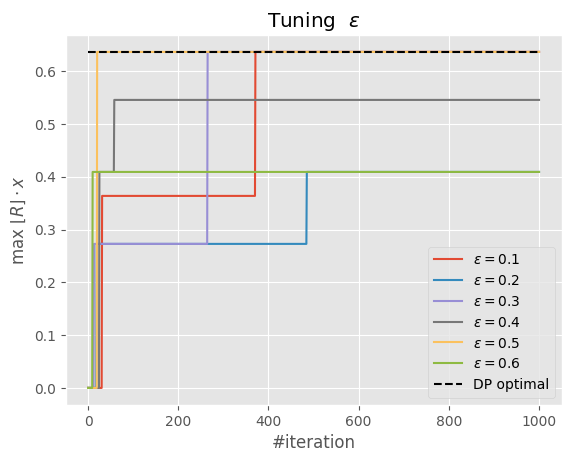

In [ ]:
with plt.style.context('ggplot'):
  for epsilon in Q_best:
    plt.plot(Q_best[epsilon],label =r'$\epsilon='+str(round(epsilon,1))+'$' )
  plt.plot(num_episodes*[f_Rx.max()],color='k',ls='dashed',label='DP optimal')
  plt.xlabel('#iteration')
  plt.ylabel(r'$\max \ \lfloor R \rfloor \cdot x$')
  plt.legend()
  plt.title(r'Tuning  $\epsilon$')
  plt.savefig('q_learning.png',dpi=100)